In [ ]:
#!pip install tensorflow==2.3.0
#!pip install gym
#!pip install keras
#!pip install keras-rl2
!pip install tensorflow==1.15.0 tensorflow-gpu==1.15.0 stable_baselines gym

     |████████████████████████████████| 412.3MB 26kB/s 
     |████████████████████████████████| 411.5MB 44kB/s 
     |████████████████████████████████| 245kB 54.0MB/s 
     |████████████████████████████████| 3.8MB 27.3MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 512kB 43.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=bf4bde5e4df79cd210e5888d8d17c4c8eaf55ef970ec53f0a99d20b2d1d10eab
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.0 which is incompatible.
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installatio

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt

import numpy as np
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Flatten
#from tensorflow.keras.optimizers import Adam

#from rl.agents import DQNAgent, DDPGAgent, NAFAgent
#from rl.policy import BoltzmannQPolicy
#from rl.memory import SequentialMemory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
class FlashFurnaceEnv(Env):
    def __init__(self):
        #Definicja wczytywania różnego rodzaju modeli pieca z różnymi parametrami 
        #file_name = "/content/drive/MyDrive/zadanie_2/models/xgb_piec_kwiecien.pkl"
        #file_name = '/content/drive/MyDrive/zadanie_2/models/xgb_piec_all_bez_temp.pkl'
        #file_name = "/content/drive/MyDrive/zadanie_2/models/xgb_piec_all_bez_temp_100s.pkl"
        file_name = "/content/drive/MyDrive/zadanie_2/models/xgb_piec_all_z_temp_100s.pkl"
        self.furnaceModel = pickle.load(open(file_name, "rb"))
        # Akcje które agent może podjąć
        # Zmienić o wartość z zakresu:
        #   -przeplywPowietrza w zakresie [-80,80] 
        #   -stezenieTlenu w zakresie [-0.1,0.1]
        #   -predkoscDmuchu w zakresie [-2.0,2.0]
        #   -pylyProcesowe w zakresie [-0.008,0.008]
        #Parametry te można dobrać eksperymentalnie w zależności od kroku regulacji jaki chcemy osiągnąć
        
        #self.action_space = Box(low=np.array([-80.0, -0.1, -2.0, -0.01]), high=np.array([80.0, 0.1, 2.0, 0.01]), dtype=np.float32)  
        #self.action_space = Box(low=np.array([-800.0, -0.013, -2.0, -0.0075]), high=np.array([800.0, 0.013, 2.0, 0.0075]), dtype=np.float32)  ## Przykładowe inne kroki regulacji
        self.action_space = Box(low=np.array([-80.0, -0.02, -2.0, -0.008]), high=np.array([80.0, 0.02, 2.0, 0.008]), dtype=np.float32)  
        
        # Definicja przestrzeni obserwacji
        #Przestrzeń obserwacji definiuje maksymalne możliwe nastawy dopuszczalne przez obiekt regulacji czyli piec zawiesinowy, przekroczenie tych wartości powoduje ukaranie agenta co zmusza go do zmiany strategii
        #Przestrzeń jest zdefiniowana następująco:
        # -ramy przeplywPowietrza w zakresie [1900,3500] 
        # -ramy stezenieTlenu w zakresie [65,81]
        # -ramy predkoscDmuchu w zakresie [40,70]
        # -ramy pylyProcesowe w zakresie [13,30]
        # - (jedyny parametr na który agent[STERNIK] nie ma wpływu bezpośrednio, parametr ten jest dobierany ze stanu środowiska z chwili t-1) ramy stratyLaczne w zakresie [0,30]
        self.observation_space = Box(low=np.array([1900.0, 65.0, 40.0, 13.0, 0.0]), high=np.array([3500.0, 81.0, 70.0, 35.0, 30.0]), dtype=np.float32)
        
        # Definicja stanu początkowego środowiska
        # 2700.0	81.0	50.0	31.0	23.298206
        self.state_przeplywPowietrza = 2700.0
        self.state_stezenieTlenu = 81.0
        self.state_predkoscDmuchu = 50.0
        self.state_pylyProcesowe = 31.0
        self.state_stratyLaczne = 23.298206
        # Definicja maksymalnego czasu trwania eksperymentu/liczby kroków regulacji 
        self.controler_length = 60 * 60 * 24
        
    def step(self, action):
        # Zastosowanie akcji na środowisku (na piecu)
        info = {}

        #Sprawdzenie czy akcja wykonana przez agenta nie przekroczy ram przestrzeni obserwacji. Przekroczenie ich powoduje ukaranie agenta co zmusza go do zmiany strategii
        check_space = np.array([
                                self.state_przeplywPowietrza + action[0],
                                self.state_stezenieTlenu + action[1],
                                self.state_predkoscDmuchu + action[2],
                                self.state_pylyProcesowe + action[3],
                                20
                                ])
        
        if not self.observation_space.contains(check_space):
            reward = -1
            self.state_stratyLaczne = self.furnaceModel.predict([[self.state_przeplywPowietrza, self.state_stezenieTlenu, self.state_predkoscDmuchu, self.state_pylyProcesowe, self.state_stratyLaczne]])[0]
            #self.state_stratyLaczne = self.furnaceModel.predict([[self.state_przeplywPowietrza, self.state_stezenieTlenu, self.state_predkoscDmuchu, self.state_pylyProcesowe]])[0]
            self.controler_length -= 1
            if self.controler_length <= 0: 
              done = True
            else:
              done = False
            return np.array([self.state_przeplywPowietrza, self.state_stezenieTlenu, self.state_predkoscDmuchu, self.state_pylyProcesowe, self.state_stratyLaczne]), reward, done, info

        #Zaaplikowanie dopuszczalnych akcji 
        self.state_przeplywPowietrza += action[0]
        self.state_stezenieTlenu += action[1]
        self.state_predkoscDmuchu += action[2]
        self.state_pylyProcesowe += action[3]
        
        #Odpytanie modelu pieca zawiesinowego o predykcję temperatury strat w następnym oknie czasowym z zaaplikowanymi akcjami
        self.state_stratyLaczne = self.furnaceModel.predict([[self.state_przeplywPowietrza, self.state_stezenieTlenu, self.state_predkoscDmuchu, self.state_pylyProcesowe, self.state_stratyLaczne]])[0]
        #self.state_stratyLaczne = self.furnaceModel.predict([[self.state_przeplywPowietrza, self.state_stezenieTlenu, self.state_predkoscDmuchu, self.state_pylyProcesowe]])[0]
        

        # Zmniejszenie licznika czasu trwania eksperymentu
        self.controler_length -= 1 
        
        # Obliczenie nagrody
        # Nagroda jest przyznawana w zależności od przedziału w jakim ma zawierać się temperatura strat 
        # Jeśli agentowi uda się tak wyregulować parametry, że znajdzie się w tym przedziale otrzyma pozytywną nagrodę/ocenę
        # Przedział można zmienić, obecnie zawiera się w przedziale [22,25]
        if self.state_stratyLaczne >= 22 and self.state_stratyLaczne <= 25: 
            reward = 1 
        else: 
            reward = -1 
        
        # Sprawdzenie czy eksperyment dobiegł końca
        if self.controler_length <= 0: 
            done = True
        else:
            done = False
        
        # Zwrócenie stanu środowiska w celu wyliczenia następnych akcji przez agenta
        return np.array([self.state_przeplywPowietrza, self.state_stezenieTlenu, self.state_predkoscDmuchu, self.state_pylyProcesowe, self.state_stratyLaczne]), reward, done, info

    def render(self):
        pass
    
    def reset(self):
        # Reset stanu środowiska
        self.state_przeplywPowietrza = 2700.0
        self.state_stezenieTlenu = 81.0
        self.state_predkoscDmuchu = 50.0
        self.state_pylyProcesowe = 31.0
        self.state_stratyLaczne = 23.298206
        self.controler_length = 60 * 60 * 24 
        return np.array([self.state_przeplywPowietrza, self.state_stezenieTlenu, self.state_predkoscDmuchu, self.state_pylyProcesowe, self.state_stratyLaczne])


In [162]:
env = FlashFurnaceEnv()

[01:35:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [140]:
from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy
from stable_baselines.common import make_vec_env
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C, ACKTR, PPO2

In [ ]:
def createFurnace():
  return FlashFurnaceEnv()

In [163]:
# Tutaj następuje uczenie agentów / równoległe eksperymenty w tym przypadku z n agentami na n modelach piecy z maksymalnymi długościami eksperymentów wynoszącymi k/n kroków regulacji
n = 1
k = 35000
env_vec = DummyVecEnv([createFurnace for _ in range(n)])

# Wybór modeli reinforcement learning wraz z politykami regulacji
model = A2C(MlpPolicy, env_vec, verbose=1)
#model = A2C(MlpLnLstmPolicy, env_vec, verbose=1)

#model = ACKTR(MlpPolicy, env_vec, verbose=1)
#model = PPO2(MlpPolicy, env_vec, verbose=1)
model.learn(total_timesteps=int(350000))

[01:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
---------------------------------
| explained_variance | 5.96e-06 |
| fps                | 487      |
| nupdates           | 7600     |
| policy_entropy     | 15       |
| total_timesteps    | 38000    |
| value_loss         | 1.39     |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 487       |
| nupdates           | 7700      |
| policy_entropy     | 15        |
| total_timesteps    | 38500     |
| value_loss         | 0.523     |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 487      |
| nupdates           | 7800     |
| policy_entropy     | 15       |
| total_timesteps    | 39000    |
| value_loss         | 6.27     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 487      |
| nupdate

In [164]:
# Testy i wizualizację osiągnięć agentów
# Jeśli finalny score jest większy niż -1 * liczba kroków regulacji w eksperymencie oznacza to, że agent był w stanie okresowo utrzymywać temperaturę strat w zadanym zakresie
# Jeśli finalny score równa się liczbie kroków regulacji w eksperymencie agent był w stanie w pełni utrzymać temperaturę strat w zadanym zakresie
# NAJWIĘKSZY wpływ na finalny score ma JAKOŚĆ MODELU PIECA czyli to jak dobrze odzwierciedla realne zachowanie pieca zawiesinowego
obs = env.reset()
done = False
score = 0
cnt = 0
acts = []
observations = []
scores = []
while not done:
    cnt += 1
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    score += reward
    acts.append(action)
    observations.append(obs)
    scores.append(score)
    if cnt % 1000 == 0:
      print(action, obs, score)

#Konwencja zapisu poniżej
#[akcje agenta na środowisku (piecu)] [zmienne z zaaplikowanymi dozwolonymi akcjami na podstawie których jest przewidywana finalna temperatura strat po danym kroku (oprócz ostatniej zmiennej w wektorze ponieważ to jest temperatura strat z kroku poprzedniego)] sumaryczny score

[-8.e+01 -2.e-02  2.e+00 -8.e-03] [2540.           80.40000001   58.           31.27200001   19.11940384] 54
[ 8.e+01  2.e-02  2.e+00 -8.e-03] [2700.           79.64000003   62.           31.032        19.52453804] -174
[ 8.e+01  2.e-02 -2.e+00 -8.e-03] [3420.           80.10000002   44.           31.44000002   18.61142921] -1072
[ 8.e+01  2.e-02 -2.e+00 -8.e-03] [2460.           79.98000002   40.           31.20000001   22.73072052] -1460
[-8.e+01  2.e-02  2.e+00  8.e-03] [2380.           79.92000002   42.           31.016        22.45986176] -1964
[-8.e+01  2.e-02  2.e+00  8.e-03] [1980.           80.54000001   52.           30.70399999   24.74701881] -2304
[-8.e+01 -2.e-02 -2.e+00  8.e-03] [2300.           80.82         48.           30.62399998   21.35251427] -2834
[-8.e+01 -2.e-02  2.e+00  8.e-03] [3260.           80.54000001   44.           30.84799999   19.08676529] -2778
[ 8.e+01 -2.e-02 -2.e+00  8.e-03] [3420.           80.38000001   40.           30.70399999   19.46279526] -3

In [165]:
acctions = np.array(acts)
observations = np.array(observations)
scores = np.array(scores)

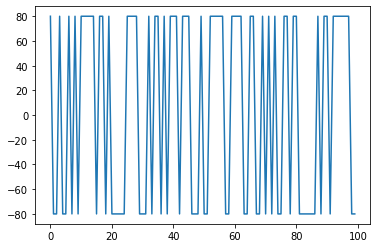

In [166]:
#manip_przeplywPowietrza	manip_stezenieTlenu	manip_predkoscDmuchu	manip_pylyProcesowe
plt.plot(acctions[:,0][:100], label = "kwant zmiany przeplywPowietrza")
plt.show()

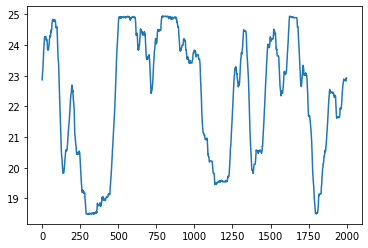

In [181]:
plt.plot(observations[:,-1][15000:17000], label = "temperatura strat")
plt.show()

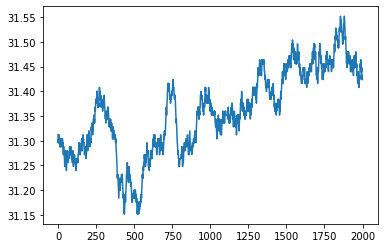

In [185]:
plt.plot(observations[:,0][15000:17000], label = "absolutna wartość pylyProcesowe")
plt.show()

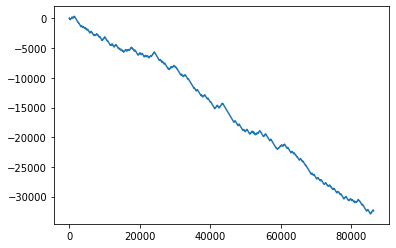

In [169]:
plt.plot(scores, label = "score")
plt.show()